In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sk
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from xgboost import XGBRegressor, plot_importance

In [2]:
#load Dataset
df = pd.read_csv('/Users/User/Desktop/PUBG_match_data.csv')

In [3]:
df = df.drop(df[df['kills'] > 7].index)
df = df.drop(df[df['heals'] > 12].index)
df = df.drop(df[df['boosts'] > 7].index)
df = df.drop(df[df['walkDistance'] > 4396].index)
df = df.drop(df[df['swimDistance'] > 123].index)
df = df.drop(df[df['rideDistance'] > 6966].index)
df = df.drop(df[df['winPlacePerc'].isna()].index)
df['healsandboosts'] = df['heals'] + df['boosts']

In [4]:
def create_group_stats(df, col):

    group_stats = df.groupby('groupId')[col].agg(['max', 'min', 'mean']).reset_index()
    group_stats = group_stats.rename({'max': f'{col}_max', 'min': f'{col}_min', 'mean': f'{col}_mean'}, axis=1)
    df = pd.merge(df, group_stats, on='groupId')

    return df

In [5]:
col_list = ['kills', 'assists', 'healsandboosts', 'walkDistance', 'swimDistance', 'rideDistance','damageDealt', 'weaponsAcquired']
for col in col_list:
    
    df = create_group_stats(df, col)

In [6]:
#Train_test_split dataset
target = 'winPlacePerc'
drop_col = ['winPlacePerc','Id','matchType','heals','boosts','kills','damageDealt','maxPlace','matchDuration', 'assists', 'healsandboosts', 'walkDistance', 'swimDistance', 'rideDistance', 'weaponsAcquired','groupId','matchId']
y = df[target]
X = df.drop(columns = drop_col)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle = True)

In [7]:
train_X.shape

(3381080, 37)

In [8]:
#Standard_Scaler
scaler = StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)

In [9]:
kfold = KFold(n_splits = 10)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


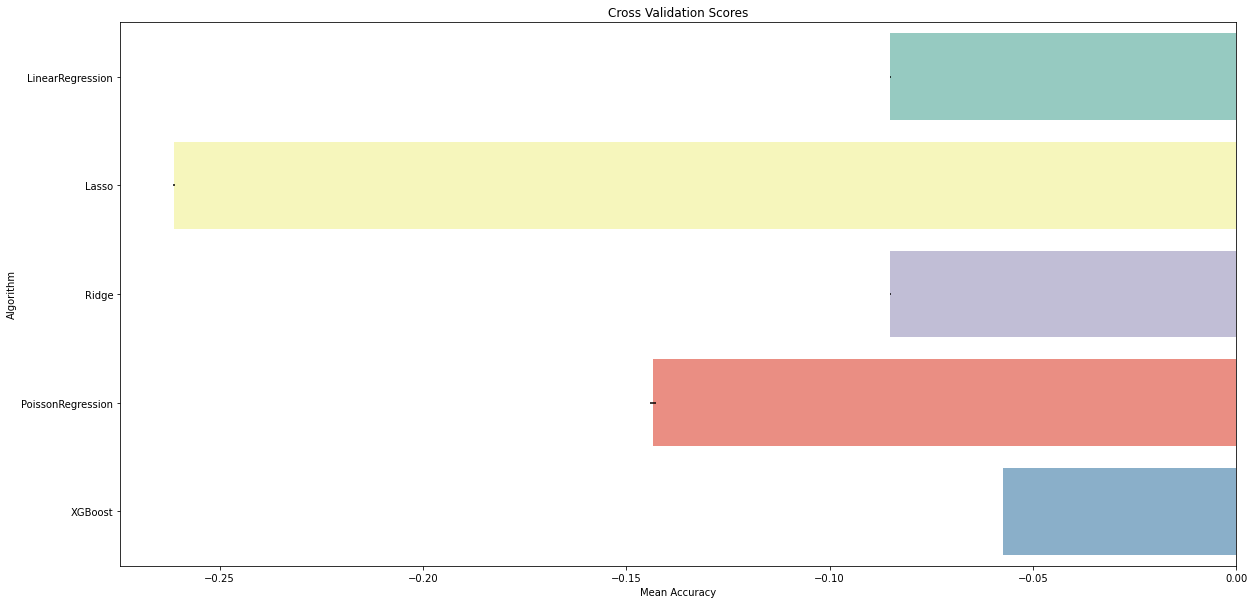

In [10]:
regressors = []
regressors.append(LinearRegression())
regressors.append(linear_model.Lasso())
regressors.append (Ridge())
regressors.append(linear_model.PoissonRegressor())
regressors.append(XGBRegressor())

# regressors.append(RandomForestRegressor())

cv_results = []
for regressor in regressors :
    X = train_X
    y = train_y
    cv_results.append(cross_val_score(regressor, X, y, scoring = 'neg_mean_absolute_error'))

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValerrors": cv_std, "Algorithm": ["LinearRegression", "Lasso", "Ridge", "PoissonRegression", "XGBoost"]})

plt.figure(figsize=(20, 10))
plot = sns.barplot("CrossValMeans", "Algorithm", data = cv_res, palette = "Set3", **{'xerr': cv_std})
plot.set_xlabel("Mean Accuracy")
plot = plot.set_title("Cross Validation Scores")

In [11]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,-0.085075,0.000101,LinearRegression
1,-0.261216,0.000191,Lasso
2,-0.085075,0.000101,Ridge
3,-0.143406,0.000752,PoissonRegression
4,-0.057411,0.000035,XGBoost


In [12]:
LNC = LinearRegression()
lr_param_grid = {"fit_intercept": ["True", "False"], "copy_X":["True", "False"]}

gsLNC = GridSearchCV(LNC, param_grid = lr_param_grid, scoring = 'neg_mean_absolute_error', verbose = 1)

gsLNC.fit(X,y)

LNC_best = gsLNC.best_estimator_

gsLNC.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


-0.08507489574465481

In [13]:
LSO = linear_model.Lasso()
lr_param_grid = {"alpha": [0.1, 0.5, 1], "fit_intercept": [True, False], "copy_X":[True, False]} 

gsLSO = GridSearchCV(LSO, param_grid = lr_param_grid, scoring = 'neg_mean_absolute_error', verbose = 1)

gsLSO.fit(X,y)

LSO_best = gsLSO.best_estimator_

gsLSO.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


-0.1494355708507094

In [14]:
RGE = Ridge()
lr_param_grid = {"alpha": [0.1, 0.5, 1], "fit_intercept": [True, False], "copy_X":[True, False]} 

gsRGE = GridSearchCV(RGE, param_grid = lr_param_grid, scoring = 'neg_mean_absolute_error', verbose = 1)

gsRGE.fit(X,y)

RGE_best = gsRGE.best_estimator_

gsRGE.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


-0.08507489620658203

In [15]:
POG = linear_model.PoissonRegressor()
lr_param_grid = {"alpha": [0.1, 0.5, 1], "fit_intercept": [True, False]} 

gsPOG = GridSearchCV(POG, param_grid = lr_param_grid, scoring = 'neg_mean_absolute_error', verbose = 1)

gsPOG.fit(X,y)

POG_best = gsPOG.best_estimator_

gsPOG.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


-0.1240588330638771

In [ ]:
XGBR = XGBRegressor()
XGBR_param_grid = {"booster": ["gbtree", "gblinear", "dart"], "max_depth": [3, 6, 9] } 

gsXGBR = GridSearchCV(XGBR, param_grid = XGBR_param_grid, scoring = 'neg_mean_absolute_error', verbose = 1)

gsXGBR.fit(X,y)

XGBR_best = gsXGBR.best_estimator_

gsXGBR.best_score_

In [ ]:
plot_importance(XGBR_best)
plt.show()

In [ ]:
importance = XGBR_best.get_booster().get_score(importance_type = 'weight')
key_list = list(test_X.columns)
value_list = list(importance.values())
importance_df = pd.DataFrame(value_list, index=key_list, columns=['weight']).sort_values(by='weight', ascending=False)
importance_df

In [ ]:
plt.figure(figsize = (40,20))
plt.barh(importance_df.index, importance_df['weight'])